tl;dr Take a VAE, constraint mean so that 0 covariance, get tuning-free disentanglement (or so it claimed)

paper: https://arxiv.org/abs/1906.11732

credit to original author for advice on implementation of proj-VAE
and https://github.com/1Konny/FactorVAE/ for data-loader and base VAE model

1.Libraries and dataset




---



In [1]:
!git clone https://github.com/deepmind/dsprites-dataset.git
!cd dsprites-dataset
!rm -rf .git* *.md LICENSE *.ipynb *.gif *.hdf5
!cd ..

fatal: destination path 'dsprites-dataset' already exists and is not an empty directory.


In [2]:
%pylab inline
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms

import random

SEED = 1
BATCH_SIZE = 512
cuda = torch.cuda.is_available()
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms


def is_power_of_2(num):
    return ((num & (num - 1)) == 0) and num != 0


class CustomTensorDataset(Dataset):
    def __init__(self, data_tensor, transform=None):
        self.data_tensor = data_tensor
        self.transform = transform
        self.indices = range(len(self))

    def __getitem__(self, index1):
        index2 = random.choice(self.indices)

        img1 = self.data_tensor[index1]
        img2 = self.data_tensor[index2]
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2

    def __len__(self):
        return self.data_tensor.size(0)

root = os.path.join('.', 'dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz')
data = np.load(root, encoding='latin1')
data = torch.from_numpy(data['imgs']).unsqueeze(1).float()
train_kwargs = {'data_tensor':data}
dset = CustomTensorDataset
train_data = dset(**train_kwargs)
train_loader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=4,
                              pin_memory=True,
                              drop_last=True)


Populating the interactive namespace from numpy and matplotlib


2. Define Model

In [0]:
Z_DIM = 10

class FactorVAE(nn.Module):
    """Encoder and Decoder architecture for 2D Shapes data."""
    def __init__(self, z_dim=Z_DIM):
        super().__init__()
        self.z_dim = z_dim
        self.encode = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(64, 64, 4, 2, 1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 1),
            nn.ReLU(True),
            nn.Conv2d(128, 2*z_dim, 1)
        )
        self.decode = nn.Sequential(
            nn.Conv2d(z_dim, 128, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 64, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
        )


    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = std.data.new(std.size()).normal_()
        return eps.mul(std).add_(mu)

    def forward(self, x, no_dec=False):
        stats = self.encode(x)
        mu = stats[:, :self.z_dim]
        mu = self.standardize(mu)
        logvar = stats[:, self.z_dim:]
        z = self.reparametrize(mu, logvar)

        if no_dec:
            return z.squeeze()
        else:
            x_recon = self.decode(z).view(x.size())
            return x_recon, mu, logvar#, z.squeeze()

    def standardize(self, mu):
        orig_shape = mu.shape
        mu = mu.view(-1,Z_DIM)
        mu_mu = mu.mean(0, keepdim=True)
        z1 = mu - mu_mu
        cov = z1.t() @ (z1/z1.size(0))
        D = torch.sqrt(torch.diag(torch.diag(cov)))
        L = torch.inverse(torch.cholesky(cov).t())
        z2 = z1 @ L @ D + mu_mu
        z2 = z2.view(orig_shape)
        return z2

model = FactorVAE().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [4]:
def loss_function(recon_x, x, mu, logvar, beta):
    # recon_loss = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    recon_loss = F.mse_loss(recon_x, x.view(recon_x.size()), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + 1+beta*KLD

LOG_INTERVAL = 50
def train(epoch, beta):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar, beta)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % LOG_INTERVAL == 0:
            print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} beta:{:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data), beta),end='')

    print('\r====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

# train
EPOCHS = 15
beta = 4
min_beta = 1
for epoch in range(1, EPOCHS + 1):
    train(epoch, beta)
    beta *= 0.7
    if beta < min_beta: 
        beta = min_beta

====> Epoch: 1 Average loss: 109.8651
====> Epoch: 2 Average loss: 65.0735
====> Epoch: 3 Average loss: 54.3277
====> Epoch: 4 Average loss: 46.5115
====> Epoch: 5 Average loss: 40.8880
====> Epoch: 6 Average loss: 39.8967
====> Epoch: 7 Average loss: 39.3212
====> Epoch: 8 Average loss: 38.8365
====> Epoch: 9 Average loss: 38.3631
====> Epoch: 10 Average loss: 38.0781
====> Epoch: 11 Average loss: 37.7796
====> Epoch: 12 Average loss: 37.4527
====> Epoch: 13 Average loss: 37.2602
====> Epoch: 14 Average loss: 37.0169
====> Epoch: 15 Average loss: 36.7672


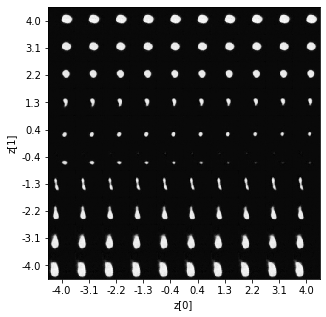

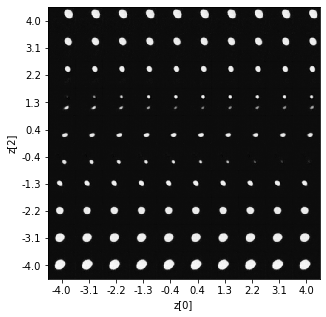

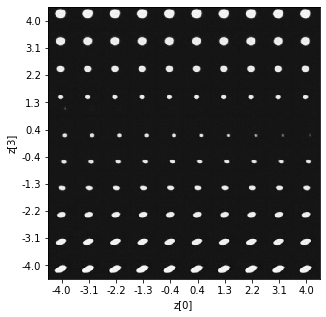

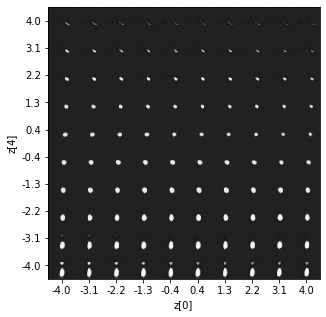

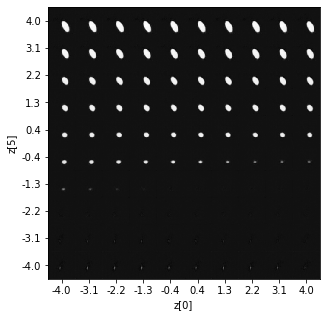

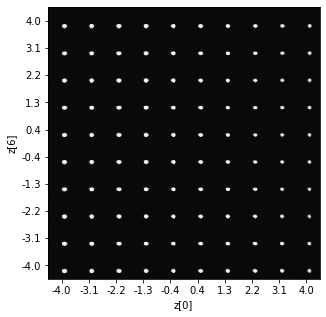

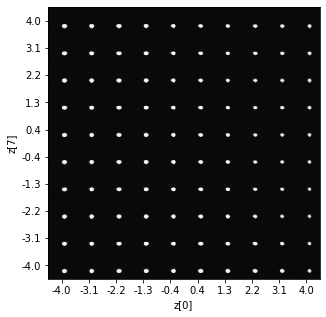

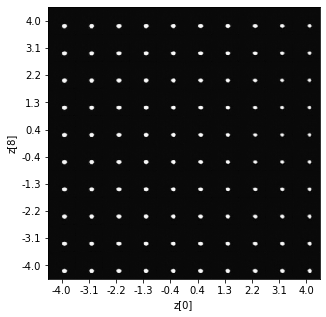

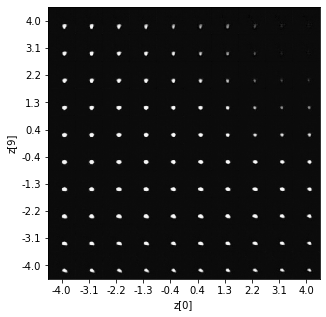

In [5]:
def plot_decoded(model, nouts=10, bound=4, dim1=0, dim2=1, constant=0,
                 model_name="vae"):
    model.eval()

    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "z_traverse.png")
    digit_size = 64
    figure = np.zeros((digit_size * nouts, digit_size * nouts))
    grid_x = np.linspace(-bound, bound, nouts)
    grid_y = np.linspace(-bound, bound, nouts)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.zeros(1, Z_DIM, 1, 1).cuda().fill_(constant)
            z_sample[:,dim1,:,:] = xi
            z_sample[:,dim2,:,:] = yi
            x_decoded = model.decode(z_sample)
            with torch.no_grad():
                digit = x_decoded.reshape(digit_size, digit_size).cpu().numpy()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    plt.figure(figsize=(5, 5))
    start_range = digit_size // 2
    end_range =  nouts * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[{}]".format(dim1))
    plt.ylabel("z[{}]".format(dim2))
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

ref = 0
for i in range(Z_DIM):
  if i==ref: continue
  plot_decoded(model, dim1=ref, dim2=i)